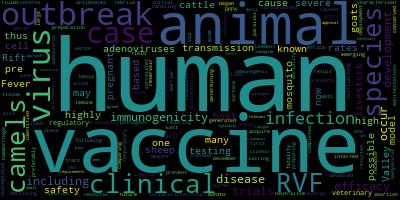

# Task

What do we know about virus genetics, origin, and evolution?

# Goal

Create a search engine that provides for a researcher the most relevant papers from a large database of documents (about 30000) in a quick overview and really fast.


# Team Darvirian
-	Henry Bol (notebook)
-	Joseph Ambrose Paragan
-	Yao Yao


# Overview and structure

Major focus has been given to make it for a **researcher** as *easy and relevant* as possible:
1. The researcher can write a search sentence as a normal sentence (the engine filters this to relevant search words) 
1. The researcher has the option to give a 'must-have-word': a dominant word in the search query 
1. A word cloud of the sentences containing search words gives a validation of the value 'in the blink of an eye'
1. The number of search words in the paper gives another impression of the focus of the document
1. The abstract is provided (if available) with the search words in red
1. The sentences of the paper which contain search words are shown with the search word in green
The solution is generic and any question considering the set of Covid-9 paper can be asked

Special attention has been given to the speed of providing the results:
- the loading (once) of the preprocessed dictionary takes about a minute 
- afterwards respons for a normal search sentence is immediate
- even case 3 with the full text (68 words) gives a respons within a few seconds


# Example case 3c (first subquestion)
Research question: 'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.'

As a must-have-word is chosen: 'farmer'.

Overall result:
* Found search words: ['evidence', 'whether', 'farmers', 'whether', 'farmers', 'could', 'played', 'role']
* Ranked papers (document numbers): [11340, 11264, 14524, 22844, 2644, 27620, 1532]

RESULT 2: Human-livestock contacts and their relationship to transmission of zoonotic pathogens, a systematic review of literature-NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/)

Wordcloud from sentences in paper containing search words giving an immediate impression of the search value:
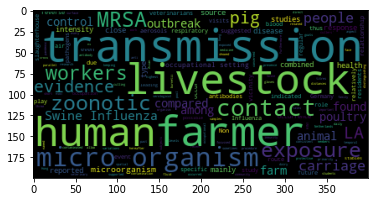

Search words (#), paper ID and authors: 
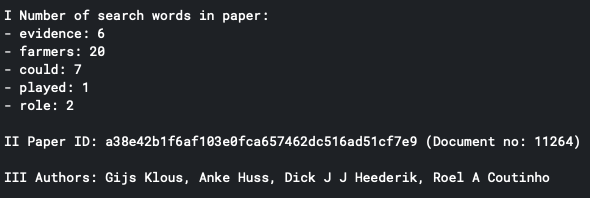

Part of abstract with search words in red:
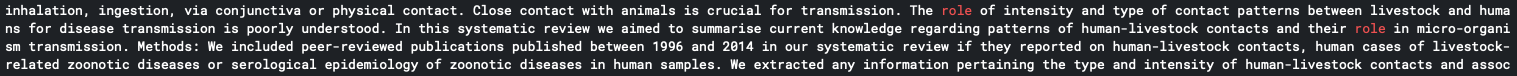

Part of sentences with search words in green:
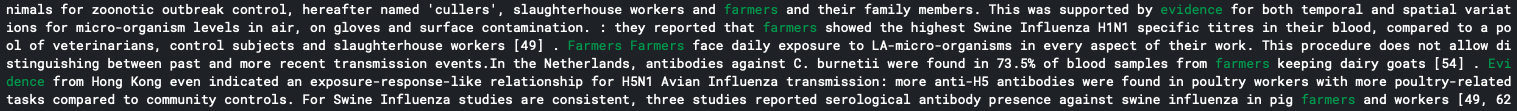

# 3 Implementation

### Parameters and relevance

Several parameters can be set to select the output from a question (‘search sentence’):
- The top n most relevant papers 
- Show the sentences per paper in which search words occur
- Show the abstract or not (if the abstarct is available) 

The **most relevant** is rule-based and uses an *intelligent combination* of several metrics: 
* Do the search words in the question appear in the same order and are these located next to each other?
* How many of the words in the question are found in a paper (100% is the best score)?
* How many times do the words occur in a document?
* What is the TF-IDF score for each word in each document?

These metrics are weighted (normalized) and summed to a Grand Score. The top 10 ranking documents are presented.


### Preprocessing
The data is preprocessed: tokenize, lemmatize, remove stopwords, vectorize (embedding), calculate TF-IDF, positions of words in documents, word2idx and idx2word. To reduce the size of the number of words single characters and words that occur only once in all documents are removed.
Main output is the **dictionary worddic** with:
* KEY: word
* VALUES: list of doc indexes where the word occurs plus per doc: word position(s) and tfidf-score
This makes it possible for the search and rank engine to determine the ranking scores.

See: https://github.com/HenryBol/darvirian/blob/master/Darvirian_Preprocessing_Engine.py

The output of the prepocessing step is loaded via pickle files in this engine.

### Further improvements
* Tuning of the combination of ranking rules to futher increase relevance
* Take care of other languages than English
* Make production version
* The preprocessed pickle files are using a lot of RAM in the Kaggle notebook

# References

### Github

https://github.com/HenryBol/darvirian

### Credits
* Inspiration: https://www.kaggle.com/amitkumarjaiswal/nlp-search-engine
* CSV files from: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv



# Contents
* PART I: Load the data
* PART II: The Search Engine: function 'search'
* PART III: The Rank Engine: function 'rank'
* PART IV: Function: 'search_sentence'
* PART V: Function: 'print_ranked_papers'
* PART VI: Examples
* PART VII: Case EUvsVirus
* PART VIII: Cases Kaggle CORD-19

# Cases Kaggle CORD-19
* CASE 1: Real-time tracking of whole genomes
* CASE 2: Access to geographic and temporal diverse sample sets
* CASE 3a (first sentence): Evidence that livestock could be infected
* CASE 3b (full text): Evidence that livestock could be infected
* CASE 3c (first subquestion): Evidence of whether farmers are infected, and whether farmers could have played a role in the origin
* CASE 3d (second subquestion): Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia
* CASE 3e (third subquestion): Experimental infections to test host range for this pathogen
* CASE 4: Animal host(s) and any evidence of continued spill-over to humans
* CASE 5: Socioeconomic and behavioral risk factors for this spill-over
* CASE 6: Sustainable risk reduction strategies

# Import the libraries

In [ ]:
from collections import Counter
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
import re
import pickle
import nltk
# nltk.download('wordnet')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install codeprofile

In [ ]:
!pip install memory_utils

In [ ]:
from codeprofile import profiler
from memory_utils import print_memory

# PART I: Load data

In [ ]:
# Load small version of df with papers
pickle_in = open('/kaggle/input/darvirian/df.pkl', 'rb')
df = pickle.load(pickle_in)

In [ ]:
print_memory()

In [ ]:
## Load pickle file worddic (numeric version)
pickle_in = open('/kaggle/input/darvirian/worddic_all_200426-2.pkl', 'rb')
worddic = pickle.load(pickle_in)

In [ ]:
print_memory()

In [ ]:
## Load pickle file word2idx
pickle_in = open('/kaggle/input/darvirian/word2idx_200426-2.pkl', 'rb')
word2idx = pickle.load(pickle_in)

In [ ]:
## Load pickle file idx2word
pickle_in = open('/kaggle/input/darvirian/idx2word_200426-2.pkl', 'rb')
idx2word = pickle.load(pickle_in)

In [ ]:
## Load pickle file sentences
pickle_in = open('/kaggle/input/darvirian/sentences_200426-2.pkl', 'rb')
sentences = pickle.load(pickle_in)

# PART II: The Search Engine

In [ ]:
# Create word search which takes multiple words (sentence) and finds documents that contain these words along with metrics for ranking:

# Output: searchsentence, words, fullcount_order, combocount_order, fullidf_order, fdic_order
# (1) searchsentence: original sentence to be searched
# (2) words: words of the search sentence that are found in the dictionary (worddic)
# (3) fullcount_order: number of occurences of search words
# (4) combocount_order: percentage of search terms
# (5) fullidf_order: sum of TD-IDF scores for search words (in ascending order)
# (6)) fdic_order: exact match bonus: word ordering score

# >>> example on limited dataset (first three docs of biorxiv))
# search('Full-genome phylogenetic analysis')
# (1) ('full-genome phylogenetic analysis',  # searchsentence: original search sentence
# (2) ['phylogenetic', 'analysis'], # words: two of the search words are in the dictionary worddic
# (3) [(1, 7), (0, 1)], # fullcount_order: the search words (as found in dict) occur in total 7 times in doc 1 and 1 time in doc 0
# (4) [(1, 1.0), (0, 0.5)], # combocount_order: max value is 1, in doc 1 all searchwords (as in dict) are present (1), in doc 0 only 1 of the 2 search words are present (0.5)
# (5) [(1, 0.0025220519886750533), (0, 0.0005167452472220973)], # fullidf_order: doc 1 has a total (sum) tf-idf of 0.0025220519886750533, doc 0 a total tf-idf of 0.0005167452472220973
# (6) [(1, 1)]) # fdic_order: doc 1 has once two search words next to each other
# <<<

def search(searchsentence, must_have_words=None):
    # split sentence into individual words
    searchsentence = searchsentence.lower()
    # split sentence in words
    words = word_tokenize(searchsentence)
    # remove duplicates in search words
     
    # add must_have_words to search words
    if must_have_words != None:
        words = must_have_words + words

    # lowercase all words
    words = [word.lower() for word in words]
                               
    # keep characters as in worddic
    words = [re.sub(r'[^a-zA-Z0-9]', '', str(w)) for w in words]
    # words = [re.sub('[^a-zA-Z0-9]+', ' ', str(w)) for w in words]
   
    # Remove single characters
    # words = [re.sub(r'\b[a-zA-Z0-9]\b', '', str(x)) for w in words]
  
    # remove empty characters
    words = [word for word in words if word]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # lemmatize search words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
 
    # remove duplicates
    words = list(set(words))
    
    # keep only the words that are in the dictionary; remove words if not in word2idx 
    [print('Word not in dictionary:', word) for word in words if word not in word2idx]
    words = [word for word in words if word in word2idx]
        
    # number of words    
    numwords = len(words)
    
    # word2idx all words
    words = [word2idx[word] for word in words]

    # Subset of worddic with only search words
    worddic_sub = {key: worddic[key] for key in words}
    
    # temp dictionaries
    enddic = {}
    idfdic = {}
    closedic = {}


    ## metrics fullcount_order and fullidf_order: 
    # sum of number of occurences of all words in each doc (fullcount_order) 
    # and sum of TF-IDF score (fullidf_order)
    for word in words:
        # print(word)
        for indpos in worddic[word]:
            # print(indpos)
            index = indpos[0]
            amount = len(indpos[1])
            idfscore = indpos[2]
            # check if the index is already in the dictionary: add values to the keys
            if index in enddic.keys():
                enddic[index] += amount
                idfdic[index] += idfscore
            # if not, just make a two new keys and store the values
            else:
                enddic[index] = amount
                idfdic[index] = idfscore
    fullcount_order = sorted(enddic.items(), key=lambda x: x[1], reverse=True)
    fullidf_order = sorted(idfdic.items(), key=lambda x: x[1], reverse=True)


    ## metric combocount_order: 
    # percentage of search words (as in dict) that appear in each doc
    words_docs = defaultdict(list)
    # get for each word the docs which it is in
    for k in worddic_sub.keys():
        for i in range(len(worddic_sub[k])):
            words_docs[k].append(worddic_sub[k][i][0])
    # keep onlt the unique docs per word      
    for k in words_docs:
        words_docs[k] = set(words_docs[k])
    # combination of all docs
    comboindex = []
    for k in words_docs:
        comboindex += words_docs[k]
    # count the number of each doc (from 0 to max number of search words)
    combocount = Counter(comboindex) 
    # divide by number of search words (to get in range from [0,1])
    for key in combocount:
        combocount[key] = combocount[key] / numwords
    # sort from highest to lowest
    combocount_order = sorted(combocount.items(), key=lambda x: x[1], reverse=True)


    ## metric closedic: 
    # check on words appearing in same order as in search
    fdic_order = 0 # initialization (in case of a single search word)
    if numwords > 1:
        # list with docs with a search word        
        x = [index[0] for record in [worddic[z] for z in words] for index in record]
        # list with docs with more than one search word
        # y = sorted(list(set([i for i in x if x.count(i) > 1])))
        counts = np.bincount(x)
        y = list(np.where([counts>1])[1])

        # dictionary of documents and all positions 
        # (for docs with more than one search word in it)
        closedic = {}
        y = set(y) # speed up processing
        for wordbig in [worddic[x] for x in words]:
            for record in wordbig:
                if record[0] in y:
                    index = record[0]
                    positions = record[1]
                    try:
                        closedic[index].append(positions)
                    except:
                        closedic[index] = []
                        closedic[index].append(positions)
    
        ## metric fdic: 
        # number of times search words appear in a doc in descending order
        fdic = {}
        # fdic_order = []
        for index in y: # list with docs with more than one search word
            x = 0 
            csum = []            
            for seqlist in closedic[index]:
                while x > 0:
                    secondlist = seqlist # second word positions
                    x = 0
                    # first and second word next to each other (in same order)
                    sol = [1 for i in firstlist if i + 1 in secondlist]
                    csum.append(sol)
                    fsum = [item for sublist in csum for item in sublist] 
                    fsum = sum(fsum) 
                    fdic[index] = fsum

                while x == 0:
                    firstlist = seqlist # first word positions 
                    x += 1 
        fdic_order = sorted(fdic.items(), key=lambda x: x[1], reverse=True)
    
    ## keep only docs that contains all must_have_words
    if must_have_words != None and numwords > 1:
        
        # lowercase all words
        must_have_words = [word.lower() for word in must_have_words]                             
        # keep characters as in worddic (without space)
        must_have_words = [re.sub(r'[^a-zA-Z0-9]', '', str(w)) for w in must_have_words]   
        # lemmatize words
        lemmatizer = WordNetLemmatizer()
        must_have_words = [lemmatizer.lemmatize(word) for word in must_have_words]
        # remove duplicates
        must_have_words = list(set(must_have_words))
        # keep only the words that are in the dictionary word2idx 
        must_have_words = [word2idx[word] for word in must_have_words if word in word2idx]

        # option: get list of all (unique) docs which have one of the must_have_words
        # must_have_!docs = set([doc[0] for word in must_have_words for doc in worddic_sub[word]])

        # option: get list of all (unique) docs which have all of the must_have_words
        # create must_have_docs from all docs with a search w
        must_have_docs = [doc[0] for word in must_have_words for doc in worddic_sub[word]]
        must_have_docs_unique = Counter(must_have_docs).most_common()
        # check if overlapping documents exist (if note give a message) 
        num_musthavewords = must_have_docs_unique[0][1] # first doc has highest occurences
        # check if no verlapping at all
        if num_musthavewords == 0: 
            print('Must have words do not have overlapping documents: search breaks')
            return
        # check if partly overlapping
        if num_musthavewords != len(must_have_words): 
            print('Must have words not 100% overlap: {} out of {}'.format(num_musthavewords, len(must_have_words)))

        else:
            # create doc list with all docs which have all must_have_words 
            must_have_docs_unique = [doc[0] for doc in must_have_docs_unique if doc[1] == num_musthavewords]      
  
            # update the score metrics containing only docs with the must have words
            fullcount_order = [list_of_list for list_of_list in fullcount_order\
                               if list_of_list[0] in must_have_docs_unique]
            combocount_order = [list_of_list for list_of_list in combocount_order\
                                if list_of_list[0] in must_have_docs_unique]    
            fullidf_order = [list_of_list for list_of_list in fullidf_order\
                             if list_of_list[0] in must_have_docs_unique]
            fdic_order = [list_of_list for list_of_list in fdic_order\
                          if list_of_list[0] in must_have_docs_unique]
    
    
    ## idx2word all words (transform words again in characters instead of numbers)
    words = [idx2word[word] for word in words]

    return (searchsentence, words, fullcount_order, combocount_order, fullidf_order, fdic_order)

# PART III: The Rank Engine

In [ ]:
# Create a rule based rank and return function

# term = "what is correlation between SARS-CoV-2 and Alzheimer's?"
# must_have_words = ['SARS-CoV-2', 'Alzheimer', 'correlation']

def rank(term, must_have_words=None):

    # get results from search
    results = search(term, must_have_words)
    # get metrics
    # search words found in dictionary:
    search_words = results[1] 
    # number of search words found in dictionary:
    num_search_words = len(results[1]) 
    # number of search words (as in dict) in each doc (in descending order):
    num_score = results[2] 
    # percentage of search words (as in dict) in each doc (in descending order):
    per_score = results[3]
    # sum of tfidf of search words in each doc (in ascending order):
    tfscore = results[4] 
    # fidc order:
    order_score = results[5] 

    # list of documents in order of relevance
    final_candidates = []

    ## no search term(s) not found
    if num_search_words == 0:
        print('Search term(s) not found')


    ## single term searched (as in dict): return the following 5 scores
    if num_search_words == 1:
        # document numbers:
        num_score_list = [l[0] for l in num_score] 
        # take max 3 documents from num_score:
        num_score_list = num_score_list[:3] 
        # add the best percentage score:
        num_score_list.append(per_score[0][0]) 
        # add the best tfidf score
        num_score_list.append(tfscore[0][0]) 
        # remove duplicate document numbers
        final_candidates = list(set(num_score_list)) 

    ## more than one search word (and found in dictionary)
    # ranking is based on an intelligent commbination of the scores
    if num_search_words > 1:

        ## set up a dataframe with scores of size all documents (initalized with 0)
        total_number_of_docs = len(df)
        doc_score_columns = ['num_score', 'per_score', 'tf_score', 'order_score']
        doc_score = pd.DataFrame(0, index=np.arange(total_number_of_docs), columns=doc_score_columns)
        
        # plot a score in a daraframe (index is doc number)
        def doc_plot(type_score):
            score_doc = [0]*total_number_of_docs
            for i in range(len(type_score)):
                x = type_score[i][0] # document number
                score_doc[x] = float(type_score[i][1]) # score
            return score_doc
        
        # Fill-in for each doc the score
        doc_score.num_score = doc_plot(num_score)
        doc_score.per_score = doc_plot(per_score)
        doc_score.tf_score = doc_plot(tfscore)
        doc_score.order_score = doc_plot(order_score)
        
        # Normalize (to the sum or max)
        # TODO CHANGE from sum to max
        normalization = sum(doc_score.num_score)
        normalization = max(doc_score.num_score)
        doc_score.num_score = [float(i)/normalization for i in doc_score.num_score]
        
        # keep per_score (percentage of search words in document) as it is (between 0 and 1)
        
        normalization = max(doc_score.tf_score)        
        doc_score.tf_score = [float(i)/normalization for i in doc_score.tf_score]
        
        normalization = max(doc_score.order_score)
        if normalization != 0:
            doc_score.order_score = [float(i)/normalization for i in doc_score.order_score]
        
        # sum all scores to get a Grand Score
        doc_score['sum'] = (doc_score.num_score +\
                            doc_score.per_score +\
                            doc_score.tf_score +\
                            doc_score.order_score)
        # keep only the values with a sum > 0
        doc_score = doc_score[doc_score['sum'] > 0]
        
        # get the docs (i.e index) sorted from high to low ranking
        final_candidates = list(doc_score.sort_values('sum', ascending=False).index)
    
        # keep top 10 candidates
        final_candidates = final_candidates[:10]        

    # print final candidates
    print('\nFound search words:', results[1])

    # top results: sentences with search words, paper ID (and document number), authors and abstract
    df_results = pd.DataFrame(columns=\
              ['Title', 'Paper_id', 'Document_no', 'Authors', 'Abstract', 'Sentences', 'Search_words'])
    for index, results in enumerate(final_candidates):
        df_results.loc[index, 'Title'] = df.title[results]
        df_results.loc[index, 'Paper_id'] = df.paper_id[results]
        df_results.loc[index, 'Document_no'] = results
        df_results.loc[index, 'Authors'] = df.authors[results]
        df_results.loc[index, 'Abstract'] = df.abstract[results]

        # get sentences with search words and all search words in the specific document
        sentence_index, search_words_found = search_sentence(results, search_words)
        # all sentences with search words
        df_results.loc[index, 'Sentences'] = sentence_index
        # all search words (also multiple instances) 
        df_results.loc[index, 'Search_words'] = search_words_found
          
    return final_candidates, df_results

# PART V: Function 'search_sentence'

In [ ]:
def search_sentence(doc_number, search_words):
    sentence_index = [] # all sentences with search words 
    search_words_found = [] # all found search words
    lemmatizer = WordNetLemmatizer()
    
    # temporarily version of document to clean
    doc = sentences[doc_number]
    # clean text
    doc = [re.sub(r'[^a-zA-Z0-9]', '', str(x)) for x in doc]
    # remove single characters
    doc = [re.sub(r'\b[a-zA-Z0-9]\b', '', str(x)) for x in doc]
    # lower case words
    doc = [word.lower() for word in doc]
    # lemmatize
    doc = [lemmatizer.lemmatize(word) for word in doc]   
    
    for i, sentence in enumerate(doc):
       
        # all search words (also multiple instances)
        for search_word in search_words:
            if search_word in sentence:
                # take original sentence
                sentence_index.append(sentences[doc_number][i])
                break
        # all search words (also multiple instances)
        for search_word in search_words:
            if search_word in sentence:
                search_words_found.append(search_word)
        # [search_words_found.append(search_word) for search_word in search_words if search_word in sentence_temp]
            
    return sentence_index, search_words_found 

# PART IV: Function 'print_ranked_papers'

In [ ]:
## Highlight in a text specific words in a specific color
# return this text with the highlighted words

def highlight_words(text, words, color):
    
    # color set
    color_set = {'red': '\033[31m', 'green': '\033[32m','blue': '\033[34m','reset': '\033[39m'}

    lemmatizer = WordNetLemmatizer() 
    
    # wrap words in color
    for word in words:
        # text_lower = text.lower() # lowercase words
        text_temp = [re.sub(r'[^a-zA-Z]', '', word) for word in text]
        # lemmatize
        text_temp = [lemmatizer.lemmatize(word) for word in text_temp] 
        # idxs = [i for i, x in enumerate(text) if x.lower() == word]
        idxs = [i for i, x in enumerate(text_temp) if x.lower() == word]
        for i in idxs:
            text[i] = color_set[color] + text[i] + color_set['reset']
            
    # join the list back into a string and print
    text_highlighted = ' '.join(text)
    return(text_highlighted)
         

## Main function of printing the papers in ranked order
# Select per document: 
# - top_n: number of top n papers to be displayed
# - show_sentences: display the sentences which contains search words
# - show_wordcloud: dsiplay a cloud word of these sentences
def print_ranked_papers(ranked_result, top_n=3, show_abstract=True, show_sentences=True):

    # print top n result (with max number of documents from ranked_result)
    for index in range(min(top_n, len(ranked_result))):    

        ## preparation        
        # list of search words
        search_words = list(set(ranked_result.Search_words[index]))

        # preparation to display wordcloud      
        text_sentences_wc = ranked_result.Sentences[index]
        text_sentences_wc = [re.sub(r'[^a-zA-Z0-9]', ' ', str(x)) for x in text_sentences_wc]
        # remove single characters
        text_sentences_wc = [re.sub(r'\b[a-zA-Z0-9]\b', '', str(x)) for x in text_sentences_wc]
        # lower case words
        text_sentences_wc = [word.lower() for word in text_sentences_wc]
        # lemmatize
        lemmatizer = WordNetLemmatizer() 
        text_sentences_wc = [lemmatizer.lemmatize(word) for word in text_sentences_wc] 
        # join all sentences and seperate by a return
        text_sentences_wc = '\n'.join(text_sentences_wc)
        # spit in seperate words
        text_sentences_split_wc = word_tokenize(text_sentences_wc)

        # preparation to print out sentences 
        # join all sentences and seperate by a return
        text_sentences = '\n'.join(ranked_result.Sentences[index])
        # Spit in seperate words 
        text_sentences_split = text_sentences.split()


        ## print most important items per document (paper)
        # and in case of 'nan' write 'not available'
       
        # ranking number and title
        if pd.isnull(ranked_result.Title[index]):
            print('\n\nRESULT {}:'. format(index+1), 'Title not available')
        else: 
                # Print Result from 1 and not 0
                print('\n\nRESULT {}:'. format(index+1), ranked_result.Title[index]) 
    
        # generate cloud word
        wordcloud = WordCloud()
        img = wordcloud.generate_from_text(' '.join(text_sentences_split_wc))
        plt.imshow(img)
        plt.axis('off')
        plt.show()   
       
        # count all search word in document and present them from highest to lowest  
        dict_search_words =\
            dict(Counter(ranked_result.Search_words.iloc[index]).most_common())
        print('\nI Number of search words in paper:')
        for k,v in dict_search_words.items():
            print('- {}:'.format(k), v)
            
        # paper id and document number
        print('\nII Paper ID:', ranked_result.Paper_id[index], 
              '(Document no.: {})'. format(ranked_result.Document_no[index]))
        
        # authors
        if pd.isnull(ranked_result.Abstract[index]):
            print('\nIII Authors:', 'Authors not available')
        else:
            print('\nIII Authors:', ranked_result.Authors[index])
        print('\n')
        
        # abstract
        if show_abstract == True:
            if pd.isnull(ranked_result.Abstract[index]):
                print('Abstract not available')
            else: 
                # split abstract in seperate words
                abstract_sentences_split = ranked_result.Abstract[index].split()
                # highlight the search words in red
                print(highlight_words(abstract_sentences_split, search_words, 'red'))
              
        ## show sentences with search words in green
        if show_sentences == True:
            print('\nIV Sentences in paper containing search words:\n')
            print(highlight_words(text_sentences_split, search_words,'green'))

# PART VI: Example

In [ ]:
# Fill in your search sentence; e.g.: 'Fullgenome phylogenetic analysis'
must_have_word = ['genome']
search_example = 'Fullgenome phylogenetic analysis'
papers, rank_result = rank(search_example, must_have_word)
# papers, rank_result = rank(search_example)

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=2, show_abstract=True, show_sentences=True)

# PART VII: Case EUvsVirus

In [ ]:
# =============================================================================
# CASE EUvsVirus: Health & Life, Research
# =============================================================================
# mapping of covid literature with perspectives of tests/medication/vaccination development
must_have_words = ['covid', 'tests', 'medication', 'vaccination', 'development']

papers, rank_result = rank('tests medication vaccination development', must_have_words)

# Print final candidates
print('Ranked papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=3, show_abstract=True, show_sentences=True)

# PART VIII: Cases Kaggle CORD-19

In [ ]:
# =============================================================================
# CASE 1: Real-time tracking of whole genomes
# =============================================================================
papers, rank_result = rank('Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=3, show_abstract=True, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 2: Access to geographic and temporal diverse sample sets
# =============================================================================
must_have_word = ['Nagoya']
papers, rank_result = rank('Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.', must_have_word)

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=1, show_abstract=False, show_sentences=True)

In [ ]:
# =============================================================================
# CASE 3a (first sentence): Evidence that livestock could be infected
# =============================================================================
papers, rank_result = rank('Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=4, show_abstract=True, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 3b (full text): Evidence that livestock could be infected
# =============================================================================
papers, rank_result = rank('Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding)\
                            and serve as a reservoir after the epidemic appears to be over.\
                            Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.\
                            Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.\
                            Experimental infections to test host range for this pathogen.')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=4, show_abstract=True, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 3c (first subquestion): Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.
# =============================================================================
must_have_word = ['farmer']
papers, rank_result = rank('Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.', must_have_word)

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=2, show_abstract=True, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 3d (second subquestion): Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.
# =============================================================================
must_have_word = ['Surveillance', 'covid']
papers, rank_result = rank('Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.', must_have_word)

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=2, show_abstract=True, show_sentences=True)

In [ ]:
# =============================================================================
# CASE 3e (third subquestion): Experimental infections to test host range for this pathogen
# =============================================================================
papers, rank_result = rank('Experimental infections to test host range for this pathogen.')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=1, show_abstract=True, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 4: Animal host(s) and any evidence of continued spill-over to humans
# =============================================================================
must_have_word = ['animal']
papers, rank_result = rank('Animal host(s) and any evidence of continued spill-over to humans', must_have_word)

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=1, show_abstract=True, show_sentences=True)

In [ ]:
# =============================================================================
# CASE 5: Socioeconomic and behavioral risk factors for this spill-over
# =============================================================================
papers, rank_result = rank('Socioeconomic and behavioral risk factors for this spill-over')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=5, show_abstract=False, show_sentences=False)

In [ ]:
# =============================================================================
# CASE 6: Sustainable risk reduction strategies
# =============================================================================
papers, rank_result = rank('Sustainable risk reduction strategies')

# Print final candidates
print('Top 10 papers (document numbers):', papers)

# Print results
print_ranked_papers(rank_result, top_n=10, show_abstract=False, show_sentences=False)